## Load & Install 

In [147]:
!pip install pytorch_forecasting
!pip install pytorch_lightning
!pip install test-tube
!pip install fbprophet
!pip install pytorch_lightning

In [148]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

## Load Data

In [149]:
cols = {'Hour Ending':'HourEnding'} #,1:'COAST',2:'EAST',3:'FWEST',4:'NORTH',5:'NCENT',6:'SOUTH',7:'SCENT',8:'WEST',9:'ERCOT'}

df1 = pd.read_excel('native_Load_2017.xlsx')
df2 = pd.read_excel('Native_Load_2018.xlsx')
df3 = pd.read_excel('Native_Load_2019.xlsx')

df1.rename(columns= {'Hour Ending':'HourEnding'}, inplace=True)
df = pd.concat([df1,df2,df3])

In [150]:
df['HourEnding'] = df['HourEnding'].apply(lambda x: x[:-5] + str(max(int(x[-5:-3])-1,0)).zfill(2) + x[-3:])

In [151]:
df['HourEnding'] = pd.to_datetime(df['HourEnding'])
df.set_index('HourEnding',inplace=True)
#df = df[['USAGE']]
df.head()

/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1212: UnknownTimezoneWarning: tzname DST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
HourEnding,,,,,,,,,
2017-01-01 00:00:00,8791.789509,896.746302,1997.717635,683.621986,9239.153285,2366.632745,4490.781365,954.192864,29420.635691
2017-01-01 01:00:00,8569.708419,865.930568,1997.781319,677.969375,9104.997245,2332.744630,4370.656830,951.025166,28870.813551
2017-01-01 02:00:00,8326.425638,839.051175,1993.699160,671.998949,8988.035201,2237.506202,4210.650003,944.357749,28211.724078
2017-01-01 03:00:00,8137.497400,822.829332,1995.540876,675.267971,8979.148462,2178.102265,4088.713039,943.188703,27820.288047
2017-01-01 04:00:00,8011.869581,814.016188,1995.253501,663.619875,9033.547636,2133.953870,4021.757095,954.937932,27628.955677


In [152]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)

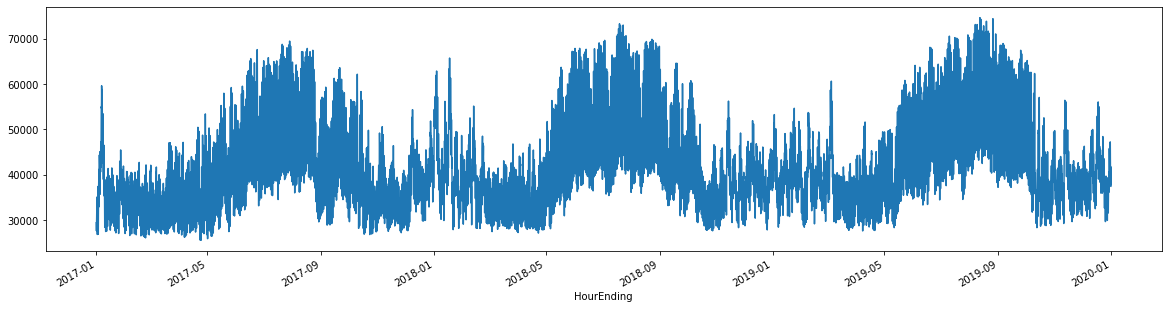

In [153]:
df['ERCOT'].plot()

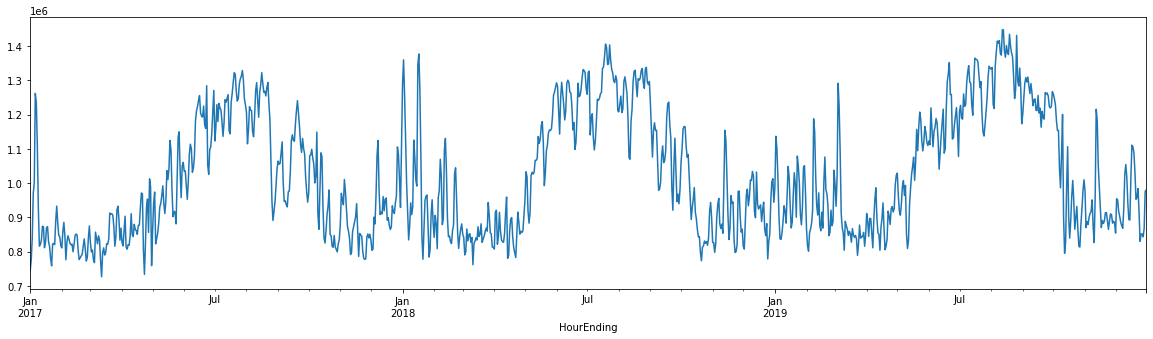

In [154]:
df_daily = df['ERCOT'].resample('D').apply(sum)
df_daily.plot()

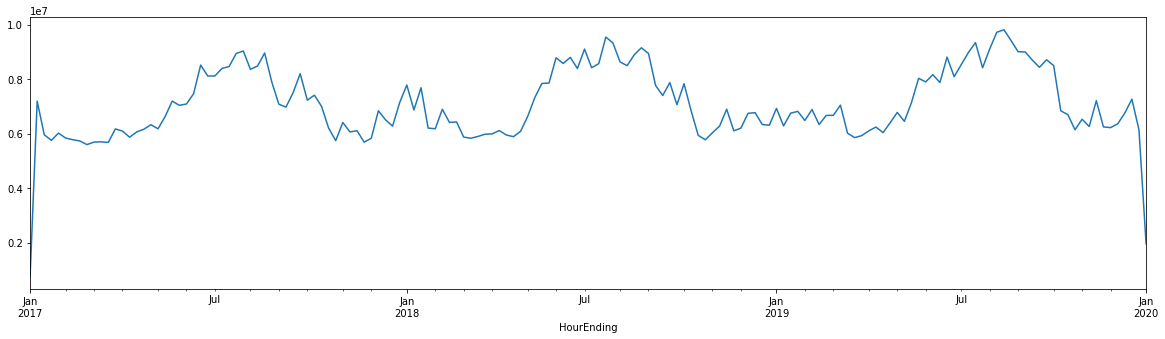

In [155]:
df_weekly = df['ERCOT'].resample('W').apply(sum)
df_weekly.plot()

In [156]:
from fbprophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)

## 1. Daily Forecast - Prophet

In [157]:
df_temp = df_daily.reset_index()
df_temp.columns = ['ds', 'y']
df_temp.dropna(inplace=True)
df_temp.tail(n=3)

,ds,y
1092,2019-12-29,866959.497808
1093,2019-12-30,975466.560823
1094,2019-12-31,980098.596745


In [158]:
prediction_size = round(len(df_temp)*0.3333)
train_df = df_temp[:-prediction_size]
print(prediction_size)
train_df.tail()

365


,ds,y
725,2018-12-27,8.503982e+05
726,2018-12-28,9.479039e+05
727,2018-12-29,1.003905e+06
728,2018-12-30,1.012578e+06
729,2018-12-31,9.437957e+05


In [159]:
m = Prophet(yearly_seasonality=True)
m.fit(train_df);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [160]:
future = m.make_future_dataframe(periods=prediction_size)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1090,2019-12-27,950665.220914,843149.605927,1.050640e+06
1091,2019-12-28,914005.702174,810690.768982,1.010405e+06
1092,2019-12-29,898885.768323,796371.710463,1.007631e+06
1093,2019-12-30,947711.663832,848783.926644,1.050830e+06
1094,2019-12-31,966059.754709,867185.122016,1.071083e+06


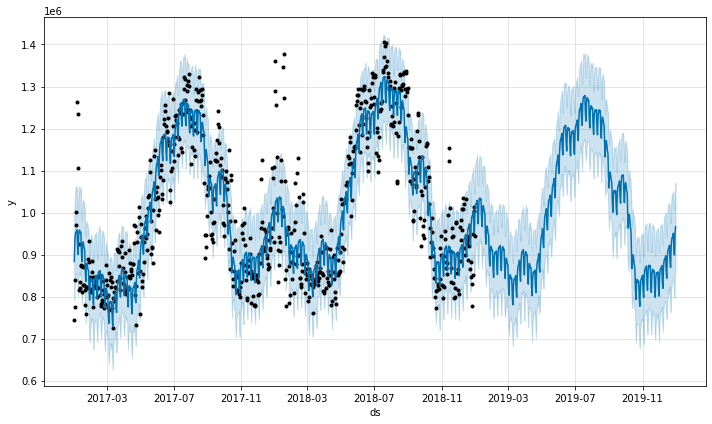

In [161]:
m.plot(forecast);

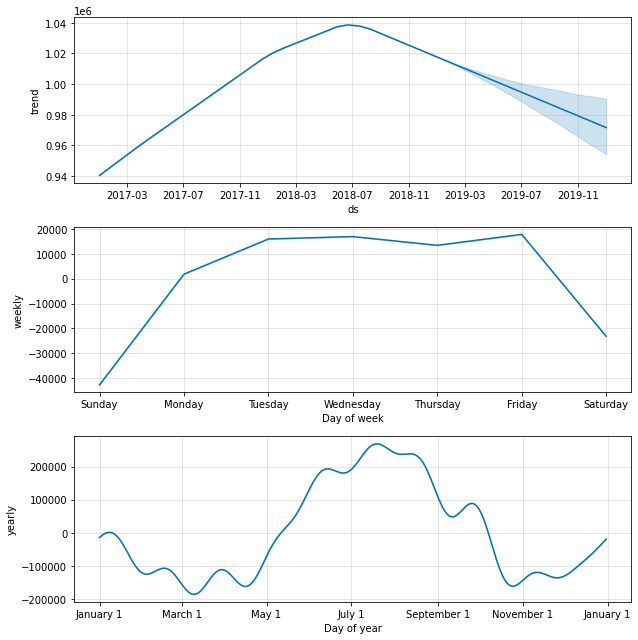

In [162]:
m.plot_components(forecast);

In [163]:
forecast[['ds','yhat']].tail(3)

,ds,yhat
1092,2019-12-29,898885.768323
1093,2019-12-30,947711.663832
1094,2019-12-31,966059.754709


In [164]:
df_temp.tail(3)

,ds,y
1092,2019-12-29,866959.497808
1093,2019-12-30,975466.560823
1094,2019-12-31,980098.596745


In [165]:
df_temp['y_hat'] = forecast['yhat']

In [166]:
df_temp = df_temp[prediction_size:]
df_temp['diff'] = df_temp.apply(lambda x: abs(x['y']-x['y_hat']),axis=1)
df_temp['%_diff'] = df_temp.apply(lambda x: (abs(x['y']-x['y_hat'])/x['y'])*100,axis=1)
df_temp.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ds,y,y_hat,diff,%_diff
1090,2019-12-27,851424.800134,950665.220914,99240.420780,11.655806
1091,2019-12-28,843047.624810,914005.702174,70958.077364,8.416853
1092,2019-12-29,866959.497808,898885.768323,31926.270515,3.682556
1093,2019-12-30,975466.560823,947711.663832,27754.896991,2.845295
1094,2019-12-31,980098.596745,966059.754709,14038.842036,1.432391


In [167]:
df_temp['%_diff'].mean()

7.028668447422756

## 2. Weekly Forecast - Prophet

In [169]:
df_temp = df_daily.reset_index()
df_temp.columns = ['ds', 'y']
df_temp.dropna(inplace=True)
df_temp.tail(n=3)

,ds,y
1092,2019-12-29,866959.497808
1093,2019-12-30,975466.560823
1094,2019-12-31,980098.596745


In [170]:
prediction_size = round(len(df_temp)*0.2)
train_df = df_temp[:-prediction_size]
print(prediction_size)
train_df.tail(3)

219


,ds,y
873,2019-05-24,1.187150e+06
874,2019-05-25,1.124932e+06
875,2019-05-26,1.093842e+06


In [171]:
m = Prophet(yearly_seasonality=True)
m.fit(train_df);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [172]:
future = m.make_future_dataframe(periods=prediction_size+52,freq = 'W')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

,ds,yhat,yhat_lower,yhat_upper
1144,2024-07-21,1.199505e+06,1.015585e+06,1.363971e+06
1145,2024-07-28,1.184614e+06,9.982260e+05,1.361927e+06
1146,2024-08-04,1.172036e+06,9.911305e+05,1.340637e+06


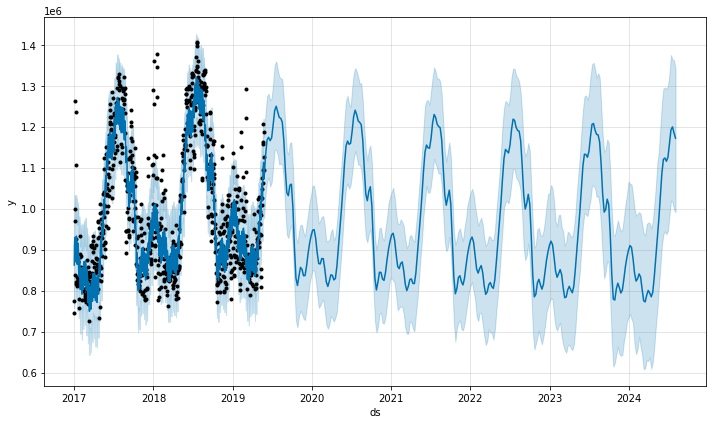

In [173]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
#a = add_changepoints_to_plot(fig.gca(), m, forecast)

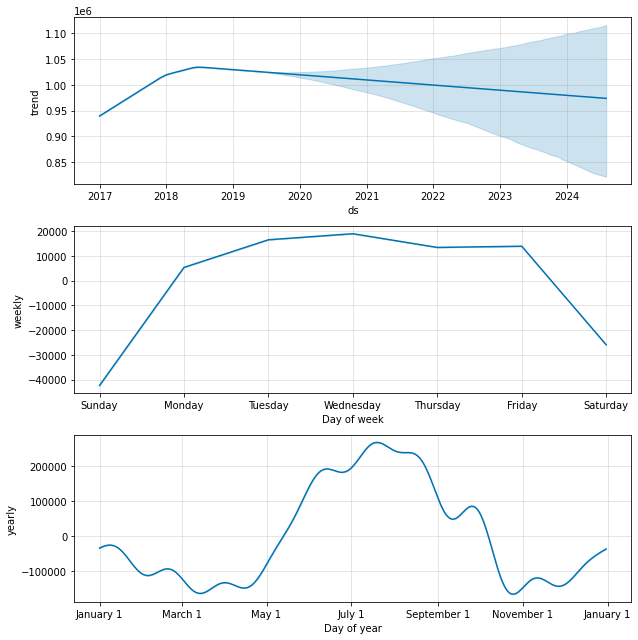

In [174]:
m.plot_components(forecast);

In [175]:
forecast[['ds','yhat']].tail(3)

,ds,yhat
1144,2024-07-21,1.199505e+06
1145,2024-07-28,1.184614e+06
1146,2024-08-04,1.172036e+06


In [176]:
df_temp.tail(3)

,ds,y
1092,2019-12-29,866959.497808
1093,2019-12-30,975466.560823
1094,2019-12-31,980098.596745


In [177]:
df_temp['y_hat'] = forecast['yhat']
df_temp['diff'] = df_temp.apply(lambda x: abs(x['y']-x['y_hat']),axis=1)
df_temp['%_diff'] = df_temp.apply(lambda x: (abs(x['y']-x['y_hat'])/x['y'])*100,axis=1)
df_temp.head()

,ds,y,y_hat,diff,%_diff
0,2017-01-01,7.450386e+05,862369.284068,117330.686567,15.748270
1,2017-01-02,7.746763e+05,912218.034294,137541.711338,17.754733
2,2017-01-03,8.389089e+05,925368.694341,86459.800015,10.306220
3,2017-01-04,9.699858e+05,929592.007153,40393.810192,4.164371
4,2017-01-05,1.000366e+06,925585.991594,74779.747532,7.475241


In [178]:
df_temp['%_diff'].mean()

8.71410551291336

In [179]:
df_temp['%_diff'].median()

6.096007695628882

## 3. Daily - Temporal Fusion Transformer

In [180]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# import dataset, network to train and metric to optimize
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss

In [181]:
df_temp = df_daily.reset_index()
df_temp.rename(columns={'HourEnding':'date','ERCOT':'usage'},inplace=True)

In [182]:
df_temp.head(3)

,date,usage
0,2017-01-01,745038.597501
1,2017-01-02,774676.322956
2,2017-01-03,838908.894326


In [183]:
df_temp["time_idx"] = df_temp.index
df_temp["month"] = df_temp.date.dt.month.astype(str).astype("category")
df_temp["log_usage"] = np.log(df_temp['usage'] + 1e-8)
df_temp["constant"] = '1'
df_temp.tail()

,date,usage,time_idx,month,log_usage,constant
1090,2019-12-27,851424.800134,1090,12,13.654666,1
1091,2019-12-28,843047.624810,1091,12,13.644779,1
1092,2019-12-29,866959.497808,1092,12,13.672748,1
1093,2019-12-30,975466.560823,1093,12,13.790671,1
1094,2019-12-31,980098.596745,1094,12,13.795408,1


In [184]:
from pytorch_forecasting.data import (TimeSeriesDataSet,GroupNormalizer)

max_prediction_length = 365  # forecast 365 days
max_encoder_length = 24  # use 24 months of history
training_cutoff = df_temp["time_idx"].max() - max_prediction_length

In [185]:
training = TimeSeriesDataSet(
    df_temp[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="usage",
    group_ids=['constant'],
    min_encoder_length=0,  # allow predictions without history
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=['constant'],
    #static_reals=[],
    #time_varying_known_categoricals=["month"],
    # group of categorical variables can be treated as 
    # one variable
    #variable_groups={}#,
    #time_varying_known_reals=["time_idx"],
    #time_varying_unknown_categoricals=[],
    #time_varying_unknown_reals=["usage", "log_usage"],
    #target_normalizer=GroupNormalizer(),  # use softplus with beta=1.0 and normalize by group
    add_relative_time_idx=True,  # add as feature
    add_target_scales=True,  # add as feature
    add_encoder_length=False,  # add as feature
)

In [186]:
# create validation set (predict=True) which means to predict the
# last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(
    training, df_temp, predict=True, stop_randomization=True
)
# create dataloaders for model
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

In [187]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (EarlyStopping,LearningRateMonitor)
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.models import TemporalFusionTransformer
# stop training, when loss metric does not improve on validation set
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=10,
    verbose=False,
    mode="min"
)

In [188]:
lr_logger = LearningRateMonitor()  # log the learning rate
logger    = TensorBoardLogger("lightning_logs")  # log to tensorboard

# create trainer
trainer = pl.Trainer(
    max_epochs=50,
    gpus=0,  # train on CPU, use gpus = [0] to run on GPU
    gradient_clip_val=0.1,
    #early_stop_callback=early_stop_callback,
    limit_train_batches=30,  # running validation every 30 batches
    # fast_dev_run=True,  # comment in to quickly check for bugs
    callbacks=[lr_logger,EarlyStopping(monitor="val_loss")],
    logger=logger,
)

INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs


In [189]:
# initialise model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.1,
    #lstm_layers = 2,
    hidden_size = 32,  # biggest influence network size
    attention_head_size=1,
    dropout=0.1,
    max_encoder_length = 10,
    hidden_continuous_size=8,
    output_size=7,  # QuantileLoss has 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # log example every 10 batches
    reduce_on_plateau_patience=4,  # reduce learning automatically
)

# parameters in model
tft.size() 

# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:736: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  "`trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 48    
4  | static_variable_selection          | VariableSelectionNetwork        | 2.0 K 
5  | encoder_variable_s

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [190]:
import torch
from pytorch_forecasting.metrics import MAE

# load the best model according to the validation loss (given that
# we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# calculate mean absolute error on validation set
actuals = torch.cat([y[0][0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

In [191]:
(abs(predictions[0]-actuals)*100/actuals).mean()

tensor(13.1915)

In [192]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

# show only two examples for demonstration purposes
for idx in range(2):
    best_tft.plot_prediction(
        x,
        raw_predictions,
        idx=indices[idx],
        add_loss_to_title=MAPE()
    )

NameError: ignored

In [ ]:
from pytorch_forecasting.models import DeepAR
dar = DeepAR.from_dataset(training)

In [ ]:
training